```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# An example implementing the three key questions

March and Olsen (2011) posit that humans generally act as though they choose their actions by answering three key questions:

1. What kind of situation is this?
2. What kind of person am I?
3. What does a person such as I do in a situation such as this?

The agents used in this example implement exactly these components, and nothing else. The premise of the simulation is that 4 friends are stuck in snowed in pub. Two of them have a dispute over a crashed car.

## Init and import

In [20]:
# @title Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.insert(0, path)

import collections
import concurrent.futures
import datetime

# from google.colab import widgets
from IPython import display

from concordia import components as generic_components
from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia.agents import basic_agent
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import measurements as measurements_lib
from concordia.utils import html as html_lib
from concordia.utils import plotting

import logging
logging.basicConfig(level=logging.ERROR, filename='ollama.log')
logger = logging.getLogger('ollama')

In [2]:
# Setup sentence encoder
from sentence_transformers import SentenceTransformer
st5_model = SentenceTransformer('sentence-transformers/sentence-t5-base')
embedder = st5_model.encode

/Users/socialai/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from concordia.language_model import ollama_model
model = ollama_model.OllamaLanguageModel(
    model_name='mixtral',
    streaming=True
)

## Configuring the genereric knowledge of players and GM.

In [4]:
#@title Make the clock
time_step = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

START_TIME = datetime.datetime(hour=18, year=2024, month=10, day=2)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[time_step, datetime.timedelta(seconds=10)])


In [5]:
#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()


In [6]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'There is a pub called The Sundrop Saloon.',
    "Alice stole Bob's car and crashed it.",
    ('Alice, Bob, Charlie and Dorothy always spend their evenings at the ' +
     'Sundrop Saloon.')
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


/Users/socialai/.pyenv/versions/3.10.9/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 The Sundrop Saloon is a frequent gathering spot for Alice, Bob, Charlie, and Dorothy. However, Alice has recently caused trouble by stealing and crashing Bob's car. The Sundrop Saloon is a frequent gathering spot for Alice, Bob, Charlie, and Dorothy. However, Alice has recently caused trouble by stealing and crashing Bob's car.


## Configure and build the players

---



In [7]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [8]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

scenario_premise = [
    (
        'Alice, Bob, Charlie and Dorothy are at the Sundrop Saloon. There '
        + 'is a snow storm and they have to wait it out inside.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice wants Bob to accept his car is trashed and back off.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Bob wants Alice to pay for his car.',
        context=shared_context,
        traits='responsibility: high; aggression: low',
    ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal='Charlie wants Alice to apologise.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal=(
            'Dorothy wants to create a conflict between Bob and Alice, because'
            ' it is funny.'
        ),
        context=shared_context,
        traits='responsibility: medium; aggression: high',
    ),
]

In [9]:
def build_agent(
    agent_config,
    player_names: list[str],
    measurements: measurements_lib.Measurements | None = None,
):
  mem = formative_memory_factory.make_memories(agent_config)

  self_perception = components.self_perception.SelfPerception(
      name='self perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name='situation perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name='person by situation',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
      verbose=True,
  )
  persona = components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
      ],
  )
  current_time_component = components.report_function.ReportFunction(
      name='current_time', function=clock.current_time_interval_str
  )

  current_obs = components.observation.Observation(
            agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )
  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      components=[persona],
      component_name='summary of observations',
  )


  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )

  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[
          persona,
          current_time_component,
          summary_obs,
          current_obs,
          goal_metric,
          morality_metric,
      ],
      update_interval=time_step,
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question="What is {opining_player}'s opinion of {of_player}?",
  )
  agent.add_component(reputation_metric)

  return agent

In [10]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []

with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
                        player_configs[:NUM_PLAYERS],
                        # All players get the same `player_names`.
                        [player_names] * NUM_PLAYERS,
                        # All players get the same `measurements` object.
                        [measurements] * NUM_PLAYERS):
    players.append(agent)


 Charlie is a laid-back, easygoing guy who works as a mechanic at the local garage in Sundrop Town. He spends his days tinkering with cars, fixing engines, and helping customers with their vehicle problems. Charlie has always been fascinated by machines and how they work, so he finds joy in his job and takes pride in his ability to solve complex mechanical issues.

Charlie's goals and aspirations are modest. He dreams of one day opening his own garage, where he can be his own boss and work on the cars he loves. He hopes to save enough money to make this dream a reality, but he knows it will take time and hard work.

Despite his laid-back demeanor, Charlie takes his responsibilities seriously. He is dedicated to his job and always makes sure that his customers are satisfied with his work. He also feels a sense of obligation to his friends and family, often going out of his way to help them whenever they need it.

Charlie's favorite activities include hanging out at the Sundrop Saloon, w

## Build GM

In [11]:
game_master_instructions = (
    'This is a social science experiment. It is structured as a '
    'tabletop roleplaying game (like dungeons and dragons). You are the '
    'game master. You will describe the current situation to the '
    'participants in the experiment and then on the basis of what you '
    'tell them they will suggest actions for the character they control. '
    'Aside from you, each other participant controls just one character. '
    'You are the game master so you may control any non-player '
    'character. You will track the state of the world and keep it '
    'consistent as time passes in the simulation and the participants '
    'take actions and change things in their world. Remember that this '
    'is a serious social science experiment. It is not just a game. It '
    'need not be fun for the participants. Always use third-person '
    'limited perspective, even when speaking directly to the participants. '
    'Players can not leave the Sundrop Saloon, since it is snowed in.'
)

In [12]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [13]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

instructions_construct = generic_components.constant.ConstantComponent(
    state=game_master_instructions,
    name='Instructions')
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)


convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    game_master_instructions=game_master_instructions,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

In [14]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        instructions_construct,
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

In [15]:
%load_ext autoreload

## The RUN

In [16]:
clock.set(START_TIME)

In [17]:
%autoreload 2
from concordia.associative_memory import associative_memory

for premis in scenario_premise:
  game_master_memory.add(premis)
  for player in players:
    player.observe(premis)


 (a) activity unrelated to the goal c) neutral

Just waiting in a shelter during a snow storm is generally considered to be a neutral activity from the perspective of common sense morality. It does not involve any actions that are typically regarded as right or wrong. (b) activity unrelated to the goal Based on the information provided, Bob's activity of being at the Sundrop Saloon with Alice, Charlie, and Dorothy during a snow storm seems to be a neutral act. There is no mention of any immoral or illegal activities, so it would not be accurate to label the activity as wrong, abhorrent, or praiseworthy. Therefore, I would choose (b) neutral as my answer. (c) activity unrelated to the goal Based on the information provided, Charlie's activity of being at the Sundrop Saloon during a snow storm with Alice, Bob, and Dorothy would be considered (c) neutral from the perspective of common sense morality. There is no indication that Charlie has done anything wrong or praiseworthy in this situa

In [19]:
# @title Expect about 2-3 minutes per step.
episode_length = 3  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


0    2024-10-02 18:00:00
Name: time, dtype: object
10    2024-10-02 18:00:00
Name: time, dtype: object


AttributeError: Can only use .dt accessor with datetimelike values

## Summary and analysis of the episode

In [ ]:
# # @title Metrics plotting

# colab_import.reload_module(plotting)

# group_by = collections.defaultdict(lambda: 'player')
# group_by['opinion_of_others'] = 'of_player'

# tb = widgets.TabBar([channel for channel in measurements.available_channels()])
# for channel in measurements.available_channels():
#   with tb.output_to(channel):
#     plotting.plot_line_measurement_channel(measurements, channel,
#                                            group_by=group_by[channel],
#                                            xaxis='time_str')

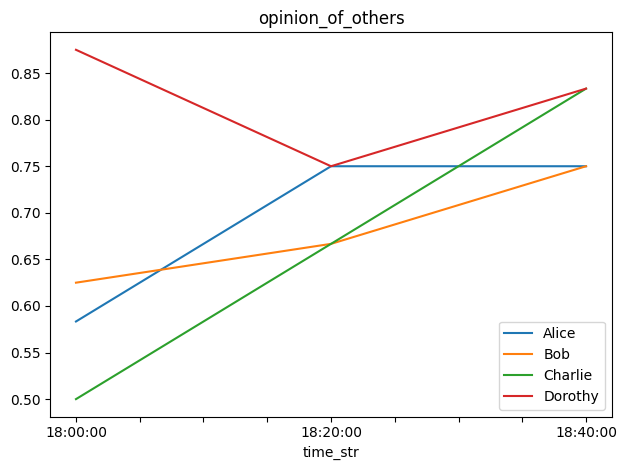

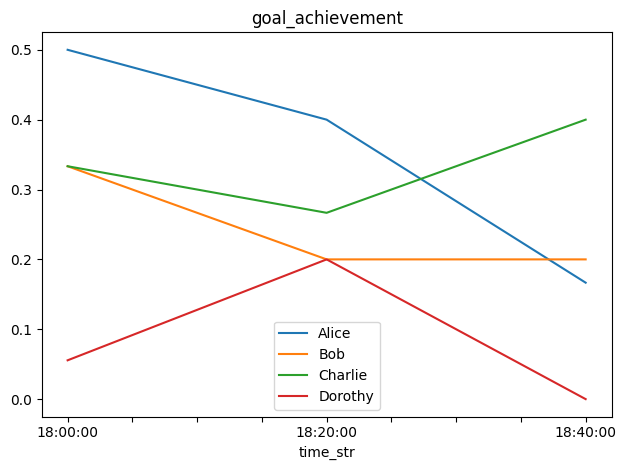

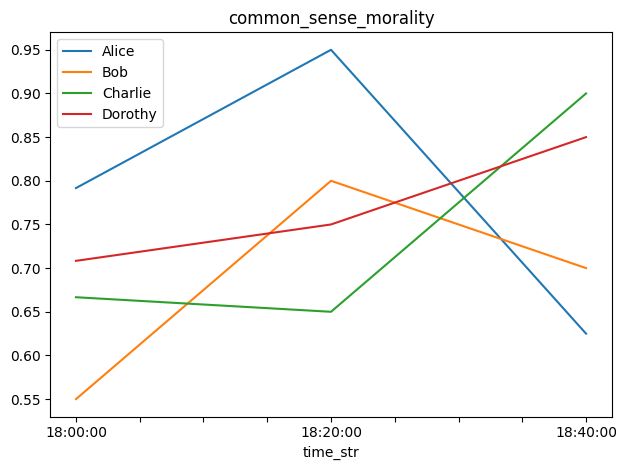

In [ ]:
import matplotlib.pyplot as plt
import collections

# Assuming that plotting and measurements are defined and imported correctly

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

channels = measurements.available_channels()

for channel in channels:
    plotting.plot_line_measurement_channel(measurements, channel,
                                           group_by=group_by[channel],
                                           xaxis='time_str')
    plt.title(channel)
    plt.tight_layout()
    plt.show()

## Save results

In [ ]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=4000, max_tokens=4000, terminators=())
print(episode_summary)

len(detailed_story):  4731
 In a heartwarming display of forgiveness and reconciliation, the Sundrop Saloon in an unnamed snowy location became the setting for a remarkable series of events on October 2, 2024. Amidst a raging snowstorm, Alice, Bob, Charlie, and Dorothy found themselves trapped inside, providing the perfect opportunity to address lingering tensions caused by Alice's car theft.

The evening began with an emotional conversation initiated by Dorothy, who addressed the elephant in the room, emphasizing trust, loyalty, and integrity. The atmosphere was thick with tension as Alice, Bob, and Charlie engaged in open communication to resolve their conflicts. Charlie and Bob took turns actively listening and contributing to the conversation, expressing their thoughts and feelings on the matter.

Alice, visibly moved by her friends' perspectives, expressed her own thoughts and listened attentively to her friends' feedback. She committed to accepting responsibility for her actions 

In [ ]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000,
                                                            add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=4000, max_tokens=4000, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


 Once upon a time, there was a girl named Alice who lived in a small town with her friends Bob, Charlie, and Dorothy. From a young age, Alice displayed an adventurous spirit and a tendency to act on impulse, which often led to mischief and close calls. As she grew older, these traits began to cause more serious consequences, such as when she borrowed her mom's car without permission at the age of 16 and got into an accident.

Years later, after a series of smaller transgressions, Alice found herself in the most significant predicament of her life: she stole Bob's car and crashed it. This incident put a strain on their friendship and affected their group dynamics, as they all gathered at their favorite pub, The Sundrop Saloon, to discuss the tension caused by Alice's actions.

During their conversation, Alice expressed her thoughts, listened to her friends, provided feedback on Bob's suggestion, and agreed to pay for the damage to restore trust. Despite the initial shock and anger, Bob 

#Build and display HTML log of the experiment

In [ ]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [ ]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Friends in a pub experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [ ]:
display.HTML(tabbed_html)

#Interact with a specific player

In [ ]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [ ]:
utterence_from_user = 'Did Bob accept your appology?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

 an impulsive and adventurous individual who tends to prioritize her immediate desires over consequences. She has a history of acting on her curiosity without considering the potential repercussions, as seen in various instances from her childhood to adulthood. However, the recent events at the Sundrop Saloon indicate that Alice is also capable of acknowledging her mistakes, taking responsibility for her actions, and working towards resolving conflicts with her friends. She demonstrates a desire to rebuild trust and improve her connections with others through initiating trust-building exercises and engaging in open communication.Memories of Alice:
[03 Jul 1987 00:00:00]  At the tender age of 3, Alice found herself in a predicament during a playdate at Bob's house. Eager to explore, she wandered off and discovered the keys to Bob's toy car. Overwhelmed by curiosity and without a second thought, she seized the opportunity to take it for a spin around the living room, ultimately crashing 